# 長距離伝送シミュレーションを行う

In [1]:
#import
import sys
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

sys.path.append('../')
from pyopt import modulate as md
from pyopt import transmission as tr
from pyopt.util import save_pickle, load_pickle

# 1. PRBS信号を伝送する

## 1.1 PRBS信号を生成する

In [2]:
N = 13  # PRBSの次数
itr = 1  # PRBSの繰り返し回数

In [3]:
bitsq = md.prbs(N=N, itr=itr)

print('ビット列: ', bitsq[:128])
print('ビット長: ', bitsq.shape)

ビット列:  [1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0
 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 0
 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1]
ビット長:  (8192,)


## 1.2 PRBS信号を変調する

In [4]:
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか

In [5]:
mdl = md.Modulate(form=form, n=n, equalize=equalize)
modsq = mdl.transform(bitsq)

print('シンボル列: ', modsq[:40])
print('シンボル長: ', modsq.shape)  # 128 / 4 * 32 = 1024

rz16QAM modulation START
シンボル列:  [0.        +0.j         0.0438346 -0.0438346j  0.08724704-0.08724704j
 0.12981925-0.12981925j 0.17114123-0.17114123j 0.21081503-0.21081503j
 0.24845856-0.24845856j 0.2837093 -0.2837093j  0.31622777-0.31622777j
 0.34570078-0.34570078j 0.37184451-0.37184451j 0.39440718-0.39440718j
 0.41317149-0.41317149j 0.42795673-0.42795673j 0.43862051-0.43862051j
 0.44506014-0.44506014j 0.4472136 -0.4472136j  0.44506014-0.44506014j
 0.43862051-0.43862051j 0.42795673-0.42795673j 0.41317149-0.41317149j
 0.39440718-0.39440718j 0.37184451-0.37184451j 0.34570078-0.34570078j
 0.31622777-0.31622777j 0.2837093 -0.2837093j  0.24845856-0.24845856j
 0.21081503-0.21081503j 0.17114123-0.17114123j 0.12981925-0.12981925j
 0.08724704-0.08724704j 0.0438346 -0.0438346j  0.        +0.j
 0.0438346 -0.0438346j  0.08724704-0.08724704j 0.12981925-0.12981925j
 0.17114123-0.17114123j 0.21081503-0.21081503j 0.24845856-0.24845856j
 0.2837093 -0.2837093j ]
シンボル長:  (65536,)


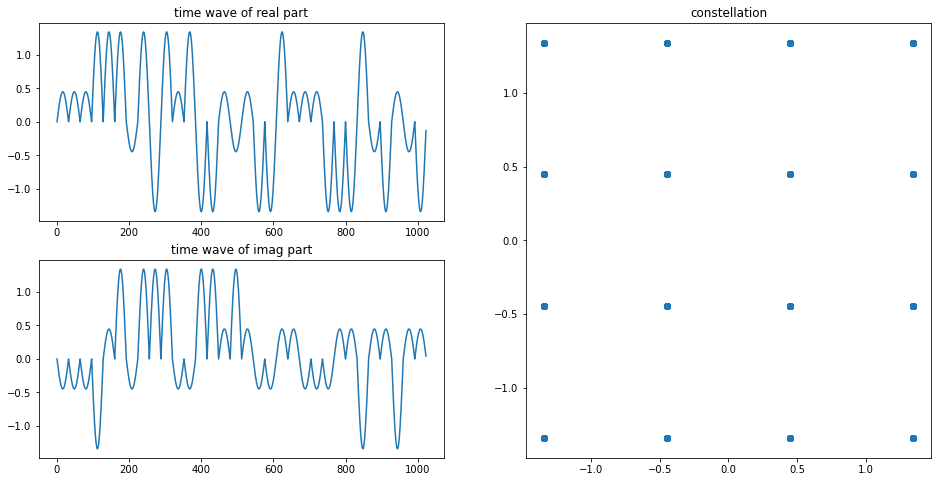

In [6]:
# 可視化
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(1, 2, 2)

ax1.plot(modsq[:32 * n].real)
ax1.set_title('time wave of real part')

ax2.plot(modsq[:32 * n].imag)
ax2.set_title('time wave of imag part')

ax3.plot(modsq[int(n/2):: n].real, modsq[int(n/2):: n].imag, 'o')
ax3.set_title('constellation');

## 1.3 16QAM変調されたPRBS信号を伝送する

In [7]:
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]

Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

In [8]:
sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                           gamma=gamma, D=D, Alpha=Alpha, NF=NF)
sgnl.transmission(Lmax=Lmax, ase=ase)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


In [9]:
signal_in = sgnl.signal['x_0']
signal_in_sampled = signal_in[int(n/2)::n]
signal = sgnl.signal['x_500']
signal_sampled = signal[int(n/2)::n]
signal_lc = sgnl.linear_compensation(Lmax, sgnl.signal['x_500'])
signal_lc_sampled = signal_lc[int(n/2)::n]

print('位相回転量(理論値): ', sgnl.phase_rotation_theo(Lmax))
print('位相回転量(シミュレーション値): ', sgnl.phase_rotation_simu(Lmax, signal_lc_sampled))
print('EVM(補償無し): ', sgnl.cal_evm(Lmax, signal_sampled))
print('EVM(100%線形補償): ', sgnl.cal_evm(Lmax, signal_lc_sampled))
print('EVM(100%線形補償+位相回転補償): ', sgnl.cal_evm_pr(Lmax, signal_lc_sampled))
print('BER(100%線形補償): ', sgnl.cal_ber(Lmax, signal_lc_sampled))
print('Q値(100%線形補償): ', sgnl.cal_qfac(Lmax, signal_lc_sampled))

位相回転量(理論値):  26.721858714928224
位相回転量(シミュレーション値):  26.68242444416632
EVM(補償無し):  139.52442159795703
EVM(100%線形補償):  46.832098558585706
EVM(100%線形補償+位相回転補償):  7.2778570779908485
BER(100%線形補償):  0.1273549776488918
Q値(100%線形補償):  1.1303501336801451


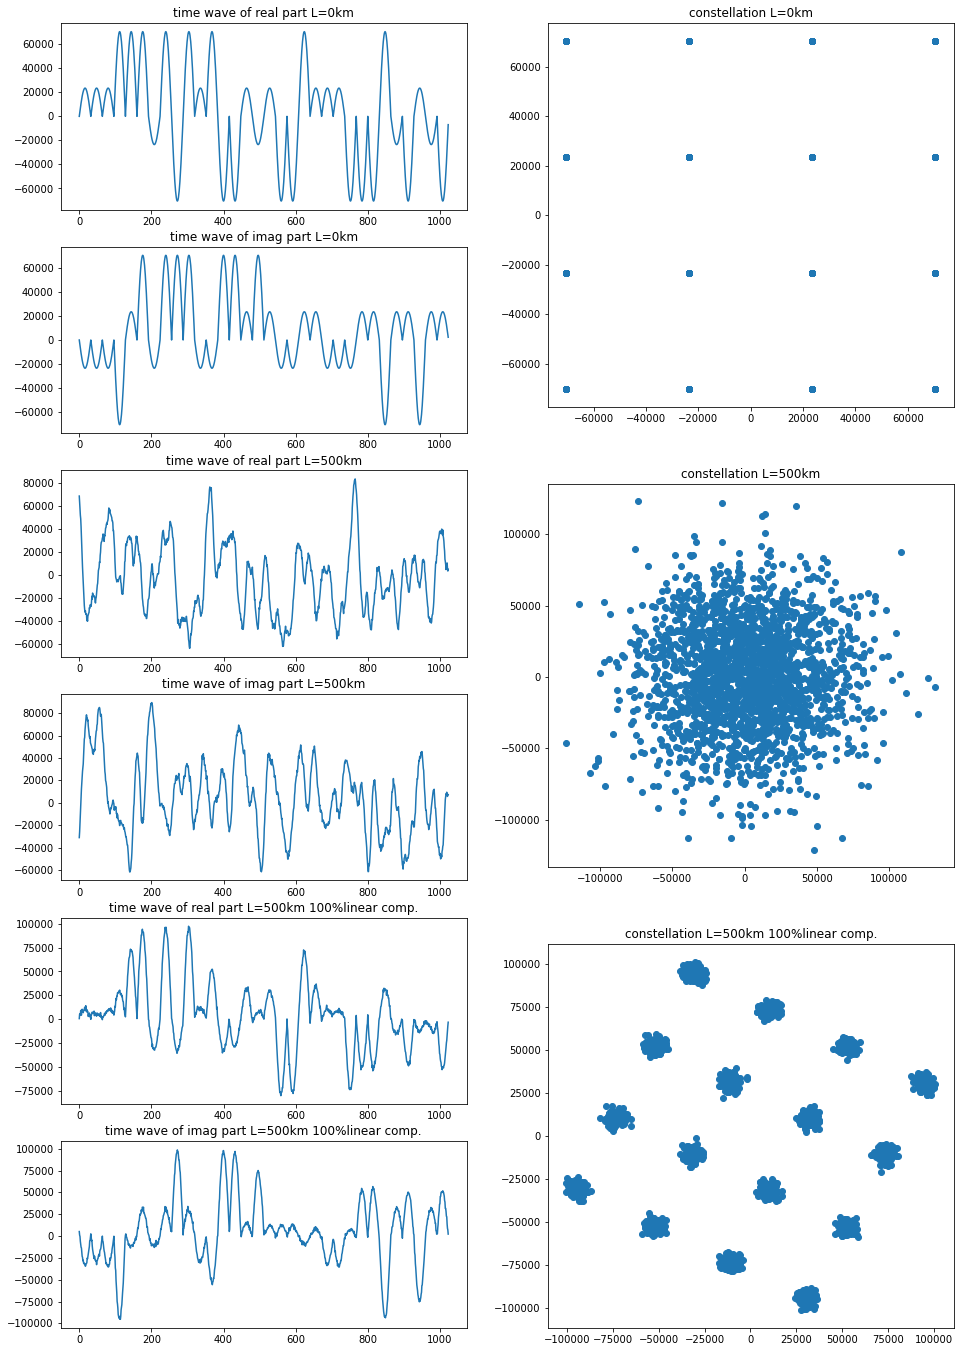

In [10]:
# 可視化
fig = plt.figure(figsize=(16, 24))
ax1 = fig.add_subplot(6, 2, 1)
ax2 = fig.add_subplot(6, 2, 3)
ax3 = fig.add_subplot(3, 2, 2)
ax4 = fig.add_subplot(6, 2, 5)
ax5 = fig.add_subplot(6, 2, 7)
ax6 = fig.add_subplot(3, 2, 4)
ax7 = fig.add_subplot(6, 2, 9)
ax8 = fig.add_subplot(6, 2, 11)
ax9 = fig.add_subplot(3, 2, 6)

ax1.plot(signal_in[:32 * n].real)
ax1.set_title('time wave of real part L=0km')
ax2.plot(signal_in[:32 * n].imag)
ax2.set_title('time wave of imag part L=0km')
ax3.plot(signal_in_sampled.real, signal_in_sampled.imag, 'o')
ax3.set_title('constellation L=0km')

ax4.plot(signal[:32 * n].real)
ax4.set_title('time wave of real part L=500km')
ax5.plot(signal[:32 * n].imag)
ax5.set_title('time wave of imag part L=500km')
ax6.plot(signal_sampled.real, signal_sampled.imag, 'o')
ax6.set_title('constellation L=500km')

ax7.plot(signal_lc[:32 * n].real)
ax7.set_title('time wave of real part L=500km 100%linear comp.')
ax8.plot(signal_lc[:32 * n].imag)
ax8.set_title('time wave of imag part L=500km 100%linear comp.')
ax9.plot(signal_lc_sampled.real, signal_lc_sampled.imag, 'o')
ax9.set_title('constellation L=500km 100%linear comp.');

## PRBS信号 伝送&dataframe追加

In [11]:
N = 17  # PRBSの次数
itr = 1  # PRBSの繰り返し回数
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 2500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

# if prbs.csv がある: pandasで読み込む　if prbs.csvがない: 新しいDataFrameを作る
df_dir = '../data/input/prbs.csv'
if os.path.exists(df_dir):
    df = pd.read_csv(df_dir, index_col=0)
else:
    cols = ['N', 'itr', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
    df = pd.DataFrame(index=[], columns=cols)
    df.to_csv(df_dir)

# 指定した条件
condition = (df['N']==N) & (df['itr']==itr) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                     (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                     (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)

# 指定した条件がprbs.csvにあるか if ある: 伝送信号を読み込みさらに伝送する if ない: 新しくPRBSを変調し伝送する
if sum(condition) > 0:
    index = df[condition].index[0]
    if df['Lmax'][index] >= Lmax:
        print('指定された条件の伝送データはすでに存在します')
    else:
        data_path = df['data_path'][index]
        sgnl = load_pickle(data_path)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)
        
        df.loc[index, 'Lmax'] = Lmax
        df.to_csv(df_dir)
else:
    # PRBSを生成し、変調・伝送する
    bitsq = md.prbs(N=N, itr=itr)
    mdl = md.Modulate(form=form, n=n, equalize=equalize)
    modsq = mdl.transform(bitsq)
    sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                               gamma=gamma, D=D, Alpha=Alpha, NF=NF)
    sgnl.transmission(Lmax=Lmax, ase=ase)
    
    # prbs.csvに伝送信号の保存先を記入する
    df = pd.read_csv(df_dir, index_col=0)
    data_path = '../data/input/prbs/prbs_' + str(len(df)).zfill(10) + '.pickle'
    save_pickle(sgnl, data_path)
    sr = pd.Series([N, itr, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
    df = df.append(sr, ignore_index=True)
    df.to_csv(df_dir)
    
df

指定された条件の伝送データはすでに存在します


,N,itr,form,n,equalize,baudrate,PdBm,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,data_path
0,13,1,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,2500,True,../data/input/prbs/prbs_0000000000.pickle
1,17,1,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,2500,True,../data/input/prbs/prbs_0000000001.pickle


# 2. Random信号を伝送する

## 2.1 Random信号を生成する

In [12]:
seed = 1234  # 乱数シード
bit_num = 128  # ビット長を指定

In [13]:
np.random.seed(seed=seed)
ransq = np.random.randint(0, 2, bit_num)

print('ビット列: ', ransq)
print('ビット長: ', ransq.shape)

ビット列:  [1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0
 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 1 1 0 0 0 1 1 1 1
 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 0 0 0 1
 1 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0]
ビット長:  (128,)


## Random信号 伝送&dataframe追加

In [14]:
seed = 1234  # 乱数シード
bit_num = 10000  # ビット長を指定
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 2500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

# if random.csv がある: pandasで読み込む　if random.csvがない: 新しいDataFrameを作る
df_dir = '../data/input/random.csv'
if os.path.exists(df_dir):
    df = pd.read_csv(df_dir, index_col=0)
else:
    cols = ['seed', 'bit_num', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path']
    df = pd.DataFrame(index=[], columns=cols)
    df.to_csv(df_dir)

# 指定した条件
condition = (df['seed']==seed) & (df['bit_num']==bit_num) & (df['form']==form) & (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & \
                     (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & \
                     (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)

# 指定した条件がrandom.csvにあるか if ある: 伝送信号を読み込みさらに伝送する if ない: 新しくrandom配列を変調し伝送する
if sum(condition) > 0:
    index = df[condition].index[0]
    if df['Lmax'][index] >= Lmax:
        print('指定された条件の伝送データはすでに存在します')
    else:
        data_path = df['data_path'][index]
        sgnl = load_pickle(data_path)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)
        
        df.loc[index, 'Lmax'] = Lmax
        df.to_csv(df_dir)
else:
    # random配列を生成し、変調・伝送する
    np.random.seed(seed=seed)
    ransq = np.random.randint(0, 2, bit_num)
    mdl = md.Modulate(form=form, n=n, equalize=equalize)
    modsq = mdl.transform(ransq)
    sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                               gamma=gamma, D=D, Alpha=Alpha, NF=NF)
    sgnl.transmission(Lmax=Lmax, ase=ase)
    
    # random.csvに伝送信号の保存先を記入する
    df = pd.read_csv(df_dir, index_col=0)
    data_path = '../data/input/random/random_' + str(len(df)).zfill(10) + '.pickle'
    save_pickle(sgnl, data_path)
    sr = pd.Series([seed, bit_num, form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path], index=df.columns)
    df = df.append(sr, ignore_index=True)
    df.to_csv(df_dir)

df

指定された条件の伝送データはすでに存在します


,seed,bit_num,form,n,equalize,baudrate,PdBm,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,data_path
0,1234,128,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,1000,True,../data/input/random/random_0000000000.pickle
1,1234,10000,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,2500,True,../data/input/random/random_0000000001.pickle


# 3. Image信号を伝送する

## 3.1 Image信号を生成する

In [15]:
target_dir = 'train'
step = 10  # (768, 1024) ---> (76, 102)
image_number = 0
ebtb = False  # 8B10Bを行うか

In [16]:
image_dir = '../data/image/'
image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
image_path = image_path_list[image_number]
print(image_path)

../data/image/train\dec2aafe511bcd90.jpg


画像サイズ:  (768, 1024, 3)


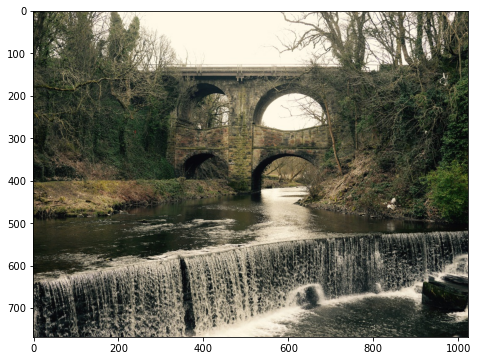

In [17]:
img = Image.open(image_path)
img_array = np.array(img)
print('画像サイズ: ', img_array.shape)

fig = plt.figure(figsize=(9, 6))
plt.imshow(img);

In [18]:
imgsq = img_array[::step, ::step].reshape(-1)

print('配列: ', imgsq)
print('配列長: ', imgsq.shape)

配列:  [79 72 17 ...  9 11 10]
配列長:  (23793,)


In [19]:
if ebtb:
    imgsq_binary = md.eightb_tenb(imgsq)
else:
    imgsq_binary = md.image_to_binary(imgsq)

print('ビット列: ', imgsq_binary[:128])
print('ビット長: ', imgsq_binary.shape)

 18%|███████████████████████▏                                                                                                            | 4180/23793 [00:00<00:00, 41392.17it/s]

image to binary START


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23793/23793 [00:00<00:00, 39470.34it/s]

ビット列:  [0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1
 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0
 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1
 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1]
ビット長:  (190344,)


## Image信号 伝送&dataframe追加

In [22]:
target_dir = 'train'
step = 10  # =10 ---> (768, 1024) ---> (76, 102)
image_number = 1
ebtb = True  # 8B10Bを行うか
form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

# if image.csv がある: pandasで読み込む　if image.csvがない: 新しいDataFrameを作る
df_dir = '../data/input/image.csv'
if os.path.exists(df_dir):
    df = pd.read_csv(df_dir, index_col=0)
else:
    cols = ['target_dir', 'step', 'image_number', 'ebtb',
                'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'data_path', 'image_path']
    df = pd.DataFrame(index=[], columns=cols)
    df.to_csv(df_dir)

# 指定した条件
condition = (df['target_dir']==target_dir) & (df['step']==step) & (df['image_number']==image_number) & (df['ebtb']==ebtb) & (df['form']==form) & \
                     (df['n']==n) & (df['equalize']==equalize) & (df['baudrate']==baudrate) & (df['PdBm']==PdBm) & (df['Ledfa']==Ledfa) & \
                     (df['stepedfa']==stepedfa) & (df['gamma']==gamma) & (df['D']==D) & (df['Alpha']==Alpha) & (df['NF']==NF) & (df['ase']==ase)

# 指定した条件がimage.csvにあるか if ある: 伝送信号を読み込みさらに伝送する if ない: 新しく画像を変調し伝送する
if sum(condition) > 0:
    index = df[condition].index[0]
    if df['Lmax'][index] >= Lmax:
        print('指定された条件の伝送データはすでに存在します')
    else:
        data_path = df['data_path'][index]
        sgnl = load_pickle(data_path)
        sgnl.transmission(Lmax=Lmax, ase=ase)
        save_pickle(sgnl, data_path)
        
        df.loc[index, 'Lmax'] = Lmax
        df.to_csv(df_dir)
else:        
    # 画像を読み込み0と1のビット列にする
    image_dir = '../data/image/'
    image_path_list = sorted(glob.glob(os.path.join(image_dir + target_dir, '*.jpg')))
    image_path = image_path_list[image_number]
    img = Image.open(image_path)
    img_array = np.array(img)
    imgsq = img_array[::step, ::step].reshape(-1)
    if ebtb:
        imgsq_binary = md.eightb_tenb(imgsq)
    else:
        imgsq_binary = md.image_to_binary(imgsq)
    
    # 画像を変調し伝送する
    mdl = md.Modulate(form=form, n=n, equalize=equalize)
    modsq = mdl.transform(imgsq_binary)
    sgnl = tr.Signal(seq=modsq, form=form, n=n, baudrate=baudrate, PdBm=PdBm, Ledfa=Ledfa, stepedfa=stepedfa,
                               gamma=gamma, D=D, Alpha=Alpha, NF=NF)
    sgnl.transmission(Lmax=Lmax, ase=ase)
    
    # image.csvに伝送信号の保存先を記入する
    df = pd.read_csv(df_dir, index_col=0)
    data_path = '../data/input/image/image_' + str(len(df)).zfill(10) + '.pickle'
    save_pickle(sgnl, data_path)
    sr = pd.Series([target_dir, step, image_number, ebtb,
                               form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, data_path, image_path], index=df.columns)
    df = df.append(sr, ignore_index=True)
    df.to_csv(df_dir)

df

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23793/23793 [00:02<00:00, 11775.90it/s]


rz16QAM modulation START


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [19:20<00:00, 232.07s/it]


,target_dir,step,image_number,ebtb,form,n,equalize,baudrate,PdBm,Ledfa,stepedfa,gamma,D,Alpha,NF,Lmax,ase,data_path,image_path
0,train,10,0,True,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,500,True,../data/input/image/image_0000000000.pickle,../data/image/train\dec2aafe511bcd90.jpg
1,train,10,1,True,RZ16QAM,32,False,28,1,100,30,1.4,16,0.16,4,500,True,../data/input/image/image_0000000001.pickle,../data/image/train\dec2addd03e136f4.jpg


In [ ]:
df.query('step == step & target_dir == "train"')

In [ ]:
df[(df['target_dir']=='train') & (df['step']==10)]

In [ ]:
(df['target_dir']=='train') & (df['step']==10)